In [49]:
import Pkg
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [50]:
using LinearAlgebra, Random, Plots

In [51]:
random_seed = 11037

11037

## First data

[0.6868500031546817, 0.23098870111176473, 0.1085705250905491, 0.9507725237055039, 0.8608928605690106, 0.5581626815809725, 0.3927871036931271, 0.5852259829106462, 0.29463320717669683, 0.5374163563943153, 0.638376735349925, 0.6117994090874137, 0.42246964757913286, 0.21060262173122413, 0.885929135266597, 0.633843948738859, 0.7278848096053306, 0.9674393733218457, 0.6807001620447348, 0.9894095360669691, 0.37895497060789163, 0.6824816844863613, 0.9791949970867497, 0.7724665048075808, 0.3023610397927915, 0.3927987774668432, 0.10647199025192944, 0.14753458073050052, 0.4942846074494327, 0.054417186911917326]

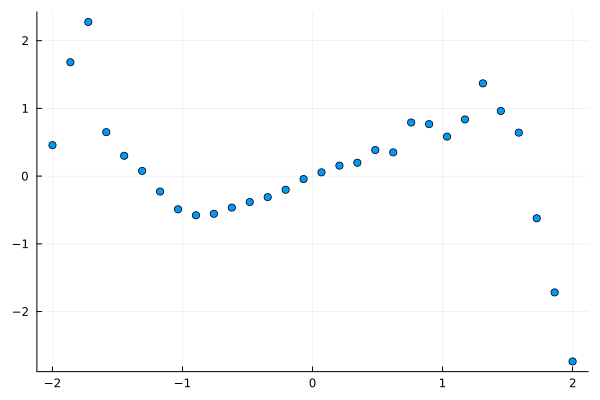

In [52]:
Random.seed!(random_seed)
n = 30
start = -2
stop = 2
eps = 1

x1 = range(start, stop, length=n)
r1 = rand(n) .* eps
print(r1)
y1 = x1.*( cos.(r1.+ 0.5.*x1.^3).+ sin.(0.5.*x1.^3) )

scatter(x1, y1, label="Data 1", legend=false, marker=:circle)

## Second data

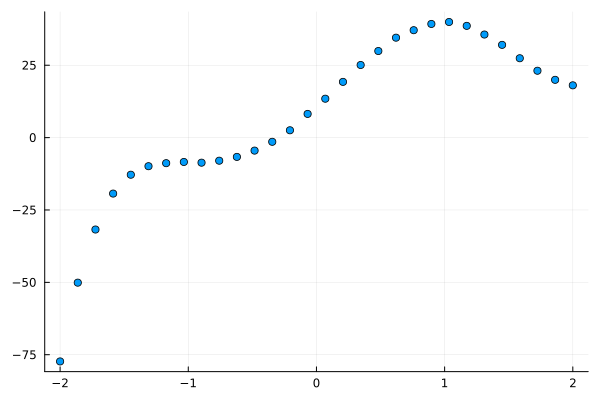

In [53]:
Random.seed!(random_seed)
n = 30
start = -2
stop = 2
eps = 1

x2 = range(start, stop, length=n)
r2 = rand(n) .* eps
y2 = 4 .* x2.^5 .- 5 .* x2.^4 .- 20 .* x2.^3 + 10 .* x2.^2 .+ 40 .* x2 .+ 10 .+ r2

scatter(x2, y2, label="Data 2", legend=false, marker=:circle)

## Solution

In [54]:
using LinearAlgebra

function gen_Vandermonde_matrix(m, n, input_data)
    """Make the matrix A with x_1, x_2, etc., raised to the power of 0, 1, 2, ..., up to m-1
    Makes a matrix with m columns and n rows (number of data points)
    """
    A = zeros(n, m)
    for exponent in 1:(m)
        A[:, exponent] = input_data[:].^(exponent-1)
    end
    return A
end

function back_substitution(U, b, m)
    """Solves the problem Ux = b for x via back substitution,
    where U is an upper triangular matrix
    """
    x = zeros(m)
    x[m] = b[m] / U[m, m]
    # from m-1 to 1 with step length -1 (so it counts m-1, m-2, ..., 2, 1)
    for i in (m-1):-1:1
        x[i] = (b[i] - sum(U[i, i+1:m] .* x[i+1:m])) / U[i, i]
    end
    return x
end

function forward_substitution(L, c, m)
    """Solves the problem Lx = c for x via forward substitution,
    where L is a lower triangular matrix
    """
    x = zeros(m)
    x[1] = c[1] / L[1, 1]
    # range 1-m with step length 1
    for i in 2:1:m
        x[i] = (c[i] - sum(L[i, 1:i-1] .* x[1:i-1])) / L[i, i]
    end
    return x
end

function QR_solution(A, b, m)
    """Uses QR factorization to find the x that minimizes the square error
    for a simple polynomial approximation of the problem Ax = b
    """
    Q1, R1 = qr(A)
    # return the reduced Q and R (Julia quirk with how qr function returns)
    Q1 = Matrix(Q1)
    R1 = Matrix(R1)
    rhs = Q1' * b
    x = back_substitution(R1, rhs, m)

    @assert isapprox(R1 * x, rhs) "R1 * x != Q1^T * b as expected"

    return x
end

function Cholesky_factorization(A)
    """Calculates the Cholesky factorization of A
    = L D L^T 
    """
    n = size(A)[1]
    L = zeros(n,n)
    D = zeros(n,n)
    # initialize with A_0
    A_k = A
    for k in 1:n
        D[k,k] = A_k[k,k] # actually A_k-1 from last loop
        # find what k-th column is, scale element k,k of l to 1
        # this will error if zero
        l_k = A_k[:, k] ./ D[k,k] # actually A_k-1 from last loop
        # update big matrix with the columns we are making
        L[:, k] = l_k
        
        A_k = A_k - D[k,k] .* (l_k * l_k')

    end
    return L, D
end

function Cholesky_factorization_symmetric(A)
    """Calculates the alternate Cholesky factorization A = RR^T
    for a symmetric matrix A
    """
    L, D = Cholesky_factorization(A)
    R = L * sqrt.(D)

    @assert isapprox(A, R*R') "A != RR^T as expected"
    
    return R
end

function Cholesky_solution(A, b, m)
    """Uses Cholesky factorization (of A^T A to guarantee A is symmetric) to find the x that minimizes the square error
    for a simple polynomial approximation of the problem Ax = b
    """
    R = Cholesky_factorization_symmetric(A'*A)
    rhs = A' * b
    rho = forward_substitution(R, rhs, m)
    x = back_substitution(R', rho, m)

    @assert isapprox(R * R' * x, rhs) "R * R^T * x != A^T * b as expected"

    return x
end

Cholesky_solution (generic function with 1 method)

In [55]:
# test cholesky algorithm with example from lecture notes on the algorithm
A = [[3,4]  [4,6]]
println(A)

L, D = Cholesky_factorization(A)
println(L)
println(D)
# difference should be zero
println(norm(L * D * L' - A))

[3 4; 4 6]
[1.0 0.0; 1.3333333333333333 1.0]
[3.0 0.0; 0.0 0.666666666666667]
0.0


In [56]:
# example 2
lambda = pi
A = [[1,1,0,0,0,0]  [1,2,1,0,0,0]  [0,1,2,1,0,0]  [0,0,1,3,1,0]  [0,0,0,1,3,1] [0,0,0,0,1,lambda] ]
println(A)

L, D = Cholesky_factorization(A)
println(L)
println(D)
# difference should be zero
println(norm(L * D * L' - A))

[1.0 1.0 0.0 0.0 0.0 0.0; 1.0 2.0 1.0 0.0 0.0 0.0; 0.0 1.0 2.0 1.0 0.0 0.0; 0.0 0.0 1.0 3.0 1.0 0.0; 0.0 0.0 0.0 1.0 3.0 1.0; 0.0 0.0 0.0 0.0 1.0 3.141592653589793]
[1.0 0.0 0.0 0.0 0.0 0.0; 1.0 1.0 0.0 0.0 0.0 0.0; 0.0 1.0 1.0 0.0 0.0 0.0; 0.0 0.0 1.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.5 1.0 0.0; 0.0 0.0 0.0 0.0 0.4 1.0]
[1.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 2.0 0.0 0.0; 0.0 0.0 0.0 0.0 2.5 0.0; 0.0 0.0 0.0 0.0 0.0 2.741592653589793]
0.0


In [57]:
# singular matrix?
A = [[3,6, -1]  [-6, -6, 1]  [2, 1, -1]]
println(A)

L, D = Cholesky_factorization(A)
println(L)
println(D)
# difference should be zero
println(norm(L * D * L' - A))

[3 -6 2; 6 -6 1; -1 1 -1]
[1.0 0.6666666666666666 -1.2000000000000002; 2.0 1.0 -0.0; -0.3333333333333333 -0.16666666666666666 1.0]
[3.0 0.0 0.0; 0.0 -18.0 0.0; 0.0 0.0 -0.8333333333333333]
15.415576538034507


In [58]:
# singular matrix?
A = [[2,-1, 0]  [-1, 2, -1]  [0, -1, 2]]
println(A)

L, D = Cholesky_factorization(A)
println(norm(L * D * L' - A))
R = Cholesky_factorization_symmetric(A)
println(R)
println(size(R))
# difference should be zero
println(norm(R*R' - A))

[2 -1 0; -1 2 -1; 0 -1 2]
0.0
[1.4142135623730951 0.0 0.0; -0.7071067811865476 1.224744871391589 0.0; 0.0 -0.8164965809277259 1.1547005383792517]
(3, 3)
6.280369834735101e-16



Data set 1
b1 is a (30,) vector
A1 is a (30, 3) matrix
Output coefficients form a (3,) vector

Data set 2
b2 is a (30,) vector
A2 is a (30, 3) matrix
Output coefficients form a (3,) vector

Data set 1
b1 is a (30,) vector
A1 is a (30, 8) matrix
Output coefficients form a (8,) vector

Data set 2
b2 is a (30,) vector
A2 is a (30, 8) matrix
Output coefficients form a (8,) vector


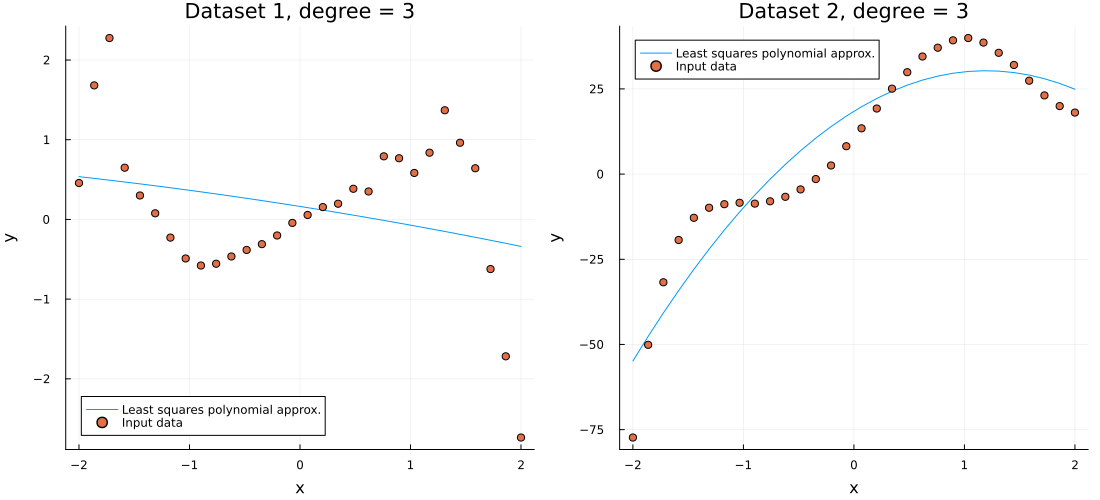

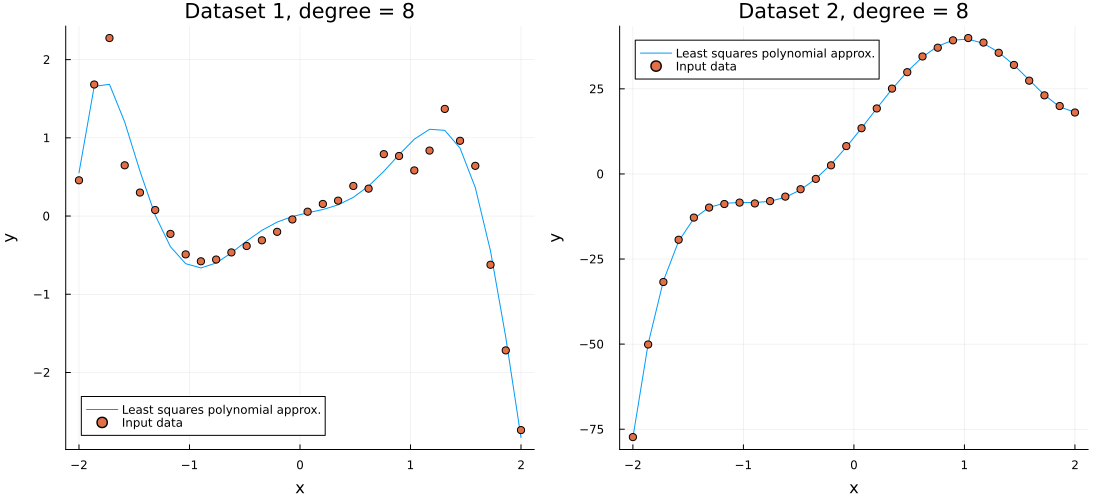

In [59]:
# QR solution
polynomial_degrees = [3,8]
for m in polynomial_degrees
    println("\nData set 1")
    b1 = y1
    println("b1 is a $(size(b1)) vector")
    A1 = gen_Vandermonde_matrix(m, n, x1)
    println("A1 is a $(size(A1)) matrix")
    polynomial_coefficients_1 = QR_solution(A1, b1, m)
    println("Output coefficients form a $(size(polynomial_coefficients_1)) vector")

    # we have the optimal coefficients, so multiply by the vandermonde matrix to get y
    y1_predicted = A1 * polynomial_coefficients_1

    # plotting
    p1 = plot(x1, y1_predicted, label="Least squares polynomial approx.")
    scatter!(x1, y1, label="Input data", legend=true, marker=:circle)
    xlabel!("x")
    ylabel!("y")
    title!("Dataset 1, degree = $m")

    println("\nData set 2")
    b2 = y2
    println("b2 is a $(size(b2)) vector")
    A2 = gen_Vandermonde_matrix(m, n, x2)
    println("A2 is a $(size(A2)) matrix")
    polynomial_coefficients_2 = QR_solution(A2, b2, m)
    println("Output coefficients form a $(size(polynomial_coefficients_2)) vector")

    # approximated output y
    y2_predicted = A2 * polynomial_coefficients_2

    # plotting
    p2 = plot(x2, y2_predicted, label="Least squares polynomial approx.")
    scatter!(x2, y2, label="Input data", legend=true, marker=:circle)
    xlabel!("x")
    ylabel!("y")
    title!("Dataset 2, degree = $m")
    
    display(plot(p1, p2, layout=(1,2), legend=true, size=(1100,500), left_margin=4Plots.mm, bottom_margin=4Plots.mm))
    savefig("QR_polynomial_approx_$(m).png")
end

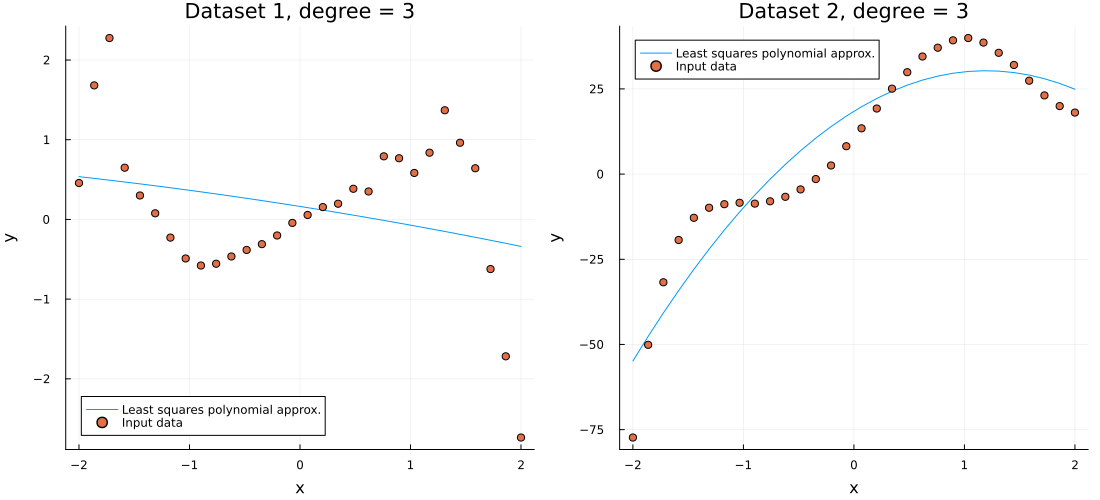


Data set 1
b1 is a (30,) vector
A1 is a (30, 3) matrix
Output coefficients form a (3,) vector

Data set 2
b2 is a (30,) vector
A2 is a (30, 3) matrix
Output coefficients form a (3,) vector

Data set 1
b1 is a (30,) vector
A1 is a (30, 8) matrix
Output coefficients form a (8,) vector

Data set 2
b2 is a (30,) vector
A2 is a (30, 8) matrix
Output coefficients form a (8,) vector


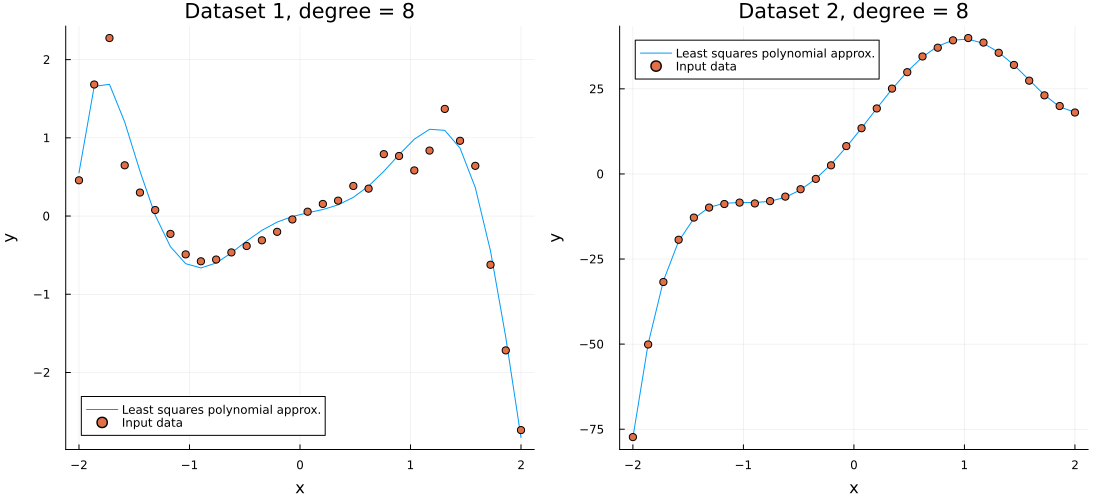

In [60]:
# Cholesky solution
polynomial_degrees = [3,8]
for m in polynomial_degrees
    println("\nData set 1")
    b1 = y1
    println("b1 is a $(size(b1)) vector")
    A1 = gen_Vandermonde_matrix(m, n, x1)
    println("A1 is a $(size(A1)) matrix")
    polynomial_coefficients_1 = Cholesky_solution(A1, b1, m)
    println("Output coefficients form a $(size(polynomial_coefficients_1)) vector")

    # we have the optimal coefficients, so multiply by the vandermonde matrix to get y
    y1_predicted = A1 * polynomial_coefficients_1

    # plotting
    p1 = plot(x1, y1_predicted, label="Least squares polynomial approx.")
    scatter!(x1, y1, label="Input data", legend=true, marker=:circle)
    xlabel!("x")
    ylabel!("y")
    title!("Dataset 1, degree = $m")

    println("\nData set 2")
    b2 = y2
    println("b2 is a $(size(b2)) vector")
    A2 = gen_Vandermonde_matrix(m, n, x2)
    println("A2 is a $(size(A2)) matrix")
    polynomial_coefficients_2 = Cholesky_solution(A2, b2, m)
    println("Output coefficients form a $(size(polynomial_coefficients_2)) vector")

    # approximated output y
    y2_predicted = A2 * polynomial_coefficients_2

    # plotting
    p2 = plot(x2, y2_predicted, label="Least squares polynomial approx.")
    scatter!(x2, y2, label="Input data", legend=:bottomright, marker=:circle)
    xlabel!("x")
    ylabel!("y")
    title!("Dataset 2, degree = $m")
    
    display(plot(p1, p2, layout=(1,2), legend=true, size=(1100,500), left_margin=4Plots.mm, bottom_margin=4Plots.mm))
    savefig("Cholesky_polynomial_approx_$(m).png")
end

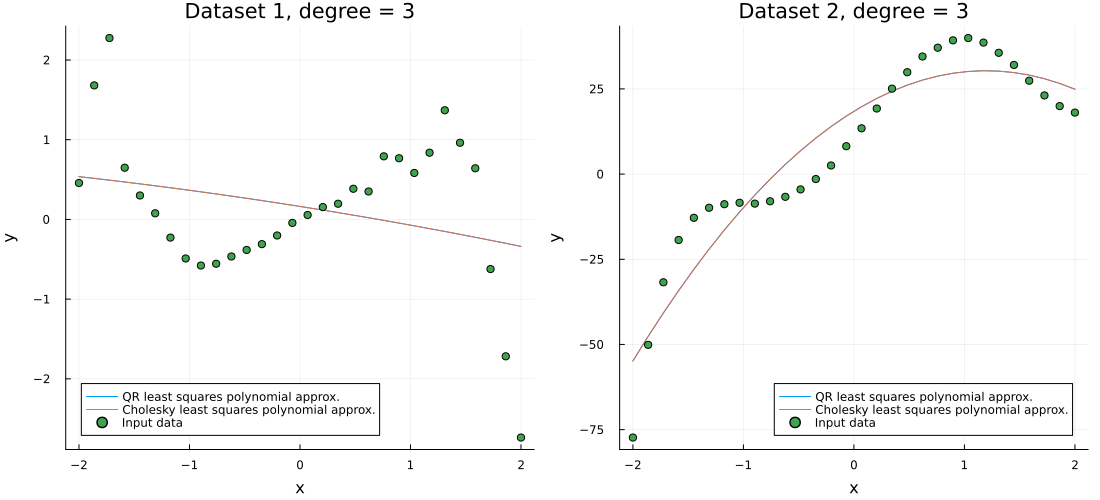


Data set 1
b1 is a (30,) vector
A1 is a (30, 3) matrix
Output coefficients form a (3,) vector

Data set 2
b2 is a (30,) vector
A2 is a (30, 3) matrix
Output coefficients form a (3,) vector

Data set 1
b1 is a (30,) vector
A1 is a (30, 8) matrix
Output coefficients form a (8,) vector

Data set 2
b2 is a (30,) vector
A2 is a (30, 8) matrix
Output coefficients form a (8,) vector


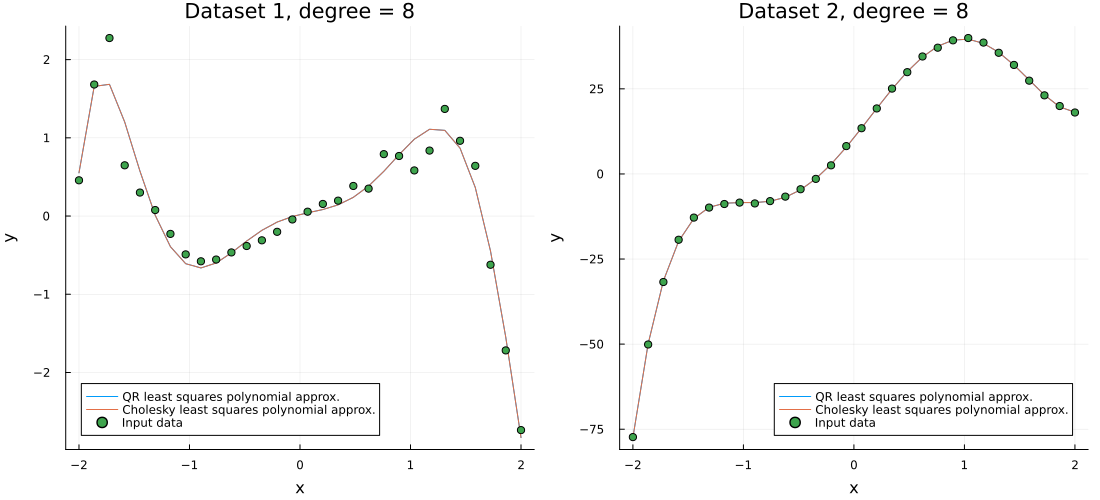

In [61]:
# Combined plots
# QR solution
polynomial_degrees = [3,8]
for m in polynomial_degrees
    println("\nData set 1")
    b1 = y1
    println("b1 is a $(size(b1)) vector")
    A1 = gen_Vandermonde_matrix(m, n, x1)
    println("A1 is a $(size(A1)) matrix")

    QR_polynomial_coefficients_1 = QR_solution(A1, b1, m)
    Cholesky_polynomial_coefficients_1 = Cholesky_solution(A1, b1, m)

    println("Output coefficients form a $(size(QR_polynomial_coefficients_1)) vector")

    # we have the optimal coefficients, so multiply by the vandermonde matrix to get y
    QR_y1_predicted = A1 * QR_polynomial_coefficients_1
    Cholesky_y1_predicted = A1 * Cholesky_polynomial_coefficients_1

    # plotting
    p1 = plot(x1, QR_y1_predicted, label="QR least squares polynomial approx.")
    plot!(x1, Cholesky_y1_predicted, label="Cholesky least squares polynomial approx.")
    scatter!(x1, y1, label="Input data", legend=true, marker=:circle)
    xlabel!("x")
    ylabel!("y")
    title!("Dataset 1, degree = $m")

    println("\nData set 2")
    b2 = y2
    println("b2 is a $(size(b2)) vector")
    A2 = gen_Vandermonde_matrix(m, n, x2)
    println("A2 is a $(size(A2)) matrix")

    polynomial_coefficients_2 = QR_solution(A2, b2, m)
    Cholesky_polynomial_coefficients_2 = Cholesky_solution(A2, b2, m)

    println("Output coefficients form a $(size(polynomial_coefficients_2)) vector")

    # approximated output y
    y2_predicted = A2 * polynomial_coefficients_2
    Cholesky_y2_predicted = A2 * Cholesky_polynomial_coefficients_2

    # plotting
    p2 = plot(x2, y2_predicted, label="QR least squares polynomial approx.")
    plot!(x2, Cholesky_y2_predicted, label="Cholesky least squares polynomial approx.")
    scatter!(x2, y2, label="Input data", legend=:bottomright, marker=:circle)
    xlabel!("x")
    ylabel!("y")
    title!("Dataset 2, degree = $m")
    
    display(plot(p1, p2, layout=(1,2), size=(1100,500), left_margin=4Plots.mm, bottom_margin=4Plots.mm))
    savefig("Combined_polynomial_approx_$(m).png")
end